### Bibliotecas

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from itertools import combinations
import multiprocessing as mp

print(f'Utilizando a versão {ox.__version__} do OSMNX')

print(f'Eu tenho {mp.cpu_count()} CPUs disponíveis')

### Parâmetros

[Estilos do Matplotlib](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)


In [ ]:
caminho = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/6_Qualificação/Mapas temáticos e figuras/BACIA_HIDROGRAFICA/SIRGAS_BACIAHIDROGRAFICA.shp'
my_crs = '4326' # Verificar em EPSG.io um projeção que te dê o resultado em metros
pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'
plt.style.use('ggplot')

verbose = False  # Flag para pular algumas atividades, com o objetivo de economizar memória.


In [ ]:
def print_colored(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m")

### Carregar e selecionar as bacias hidrográficas

In [ ]:
# Informações relevantes sobre os sistemas de coordenadas do GeoSampa
#Nota técnica: No GeoSampa são fornecidos arquivos tanto na projeção SAD69(96) como SIRGAS2000 e WGS84. 
#A projeção em SAD69(96) é fornecida apenas em caráter de compatibilidade com bases antigas, visto que, em 2014,
#foi definida a projeção UTM/SIRGAS2000 (EPGS: 31983) como a nova referência para o Sistema Geodésico Brasileiro (SGB)
# e para o Sistema Cartográfico Nacional (SCN). Desde então são consideradas oficiais apenas as informações
# produzidas tendo o Sirgas2000 como sistema geodésico.

# Read the shapefile
gdf = gpd.read_file(caminho)

# Atribuição do esquema de projeção
gdf = gdf.set_crs(epsg=31983)
gdf = gdf.to_crs(my_crs)

# Verifica o sistema de coordenadas
print(f'O sistema de coordendadas utilizado é o {gdf.crs}')

# Plotar o geodataframe
gdf.plot()

# Verifica os nomes das bacias presentes no arquivo
bacias_unicas = gdf['BACIA_NOME'].unique()
#print(bacias_unicas)

# Bacia desejada
bacia = 'Aricanduva'

# Filtrar as linhas que contêm a palavra procurada
linhas_contendo_bacia = filter(lambda linha: bacia in linha, bacias_unicas)

# Converter o resultado de volta para uma lista, se necessário
linhas_contendo_bacia = list(linhas_contendo_bacia)

# Exibir as linhas encontradas

for linha in linhas_contendo_bacia:
    print(linha)

In [ ]:
# Filtrando para a bacia do Aricanduva
gdf_Aricanduva = gdf[gdf['BACIA_NOME'].isin(linhas_contendo_bacia)]

gdf_Aricanduva.plot()

print(gdf_Aricanduva.crs)

### Fazer o download da rede viária correspondente a bacia

In [ ]:
# Encontre os limites máximos e mínimos das coordenadas do GeoDataFrame
min_x, min_y, max_x, max_y = gdf_Aricanduva.total_bounds

# Certifique-se de que o CRS do seu GeoDataFrame está definido corretamente
#my_crs = gdf_Aricanduva.crs

# Crie um polígono representando a caixa delimitadora
bounding_box = box(min_x, min_y, max_x, max_y)

# Crie um novo GeoDataFrame com o polígono da caixa delimitadora
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs=my_crs)
    
# Use a função graph_from_polygon() do OSMNx para extrair a rede correspondente ao polígono
G = ox.graph_from_polygon(bounding_box, network_type='drive')
G = ox.add_edge_speeds(G) # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

if verbose:
    # Este bloco será executado somente se verbose for True
    fig, ax = ox.plot_graph(G)
    plt.show()


In [ ]:
node, edges = ox.graph_to_gdfs(G)
if verbose:
    edges.explore(column = "speed_kph",
                tooltip = "speed_kph",
                popup = True,
                tiles = "CartoDB dark_matter",
                cmap = "inferno_r")

In [ ]:
print("\nO comprimento total dessa rede é \033[1;31m{:,.2f} quilômetros\033[0m\n".format(edges['length'].sum()/1000))

### Simplificar a rede

In [ ]:
def remover_atributos(lista, atributos_para_remover):
    """
    Remove um atributo específico de uma lista e formata o resultado como uma string.

    Args:
    - lista: A lista de elementos.
    - atributo_para_remover: O atributo que deseja remover da lista.

    Returns:
    - Uma string formatada no formato: '['highway'˜'Atributo1|Atributo2|etc']'
      contendo todos os elementos da lista original, exceto o atributo especificado.
    """
    lista_sem_atributo = [item for item in lista if item not in atributos_para_remover]
    atributos_formatados = '|'.join(lista_sem_atributo)
    return "['highway'~'{}']".format(atributos_formatados)

In [ ]:
edges_explodido = edges.explode('highway')
valores_unicos = edges_explodido['highway'].unique()
print('\nOs valores únicos da tag highway são:\n{}',valores_unicos)

atributos_remover = ['residential', 'busway', 'unclassified', 'living_street']
print('\nOs valores removidos da tag highway são:\n{}',atributos_remover)

resultado_formatado = remover_atributos(valores_unicos, atributos_remover)
print('\nA lista com os valores removidaos é:\n{}',resultado_formatado)  # Saída: '['highway'˜'Atributo1|Atributo3']'

# Obter o grafo da rede de ruas aplicando o filtro personalizado
#Detalhes em https://wiki.openstreetmap.org/wiki/Highway:International_equivalence
cf = resultado_formatado
G2 = ox.graph_from_polygon(bounding_box, network_type='drive', custom_filter=cf)

# Conforme o Código de Trânsito Brasileiro (CTB), em vias urbanas, a velocidade máxima permitida é a seguinte, na ausência de 
#sinalização específica:

# Vias arteriais: 60 km/h
# Vias coletoras: 40 km/h
# Vias locais: 30 km/h
# No entanto, muitas cidades, incluindo São Paulo, adotam regulamentações específicas. Em São Paulo, a regulamentação local estabeleceu que a velocidade padrão, na ausência de sinalização, é de 50 km/h para vias urbanas principais.

G2 = ox.routing.add_edge_speeds(G2, fallback=50) # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph
#fig, ax = ox.plot_graph(G2)
#plt.show()
node2, edges2 = ox.graph_to_gdfs(G2)
print("\nO comprimento total dessa rede é \033[1;31m{:,.2f} quilômetros\033[0m\n".format(edges2['length'].sum()/1000))
if verbose:
    edges2.explore(column = "speed_kph",
                tooltip = "speed_kph",
                popup = True,
                tiles = "CartoDB dark_matter",
                cmap = "inferno_r")

Ao incorporar as velocidades do OSM no grafo, a biblioteca OSMNx faz algumas atualizações. Verificar [aqui](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.add_edge_speeds) para maiores detalhes.

In [ ]:
# Verificação final das velocidades adicionadas
velocidades_produzidas = edges2['speed_kph'].unique()
print(f'\n São {len(velocidades_produzidas)} valores de velocidade, representados abaixo: \n {velocidades_produzidas}')

In [ ]:
# Substituir valores de speed_kph acima de 35
edges2.loc[(edges2['speed_kph'] > 35) & (edges2['speed_kph'] < 45), 'speed_kph'] = 40
edges2.loc[(edges2['speed_kph'] > 45) & (edges2['speed_kph'] < 55), 'speed_kph'] = 50

velocidades_produzidas2 = edges2['speed_kph'].unique()
print(f'\n São {len(velocidades_produzidas2)} valores de velocidade, representados abaixo: \n {velocidades_produzidas2}')

### Análise estatística da rede viária


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd

In [ ]:
# Visão Geral dos Dados
print_colored('Visão geral do geodataframe: \n',34)
print(edges2.describe(include='all'))

In [ ]:
print_colored('\n Visão geral dos tipos de dados: \n', 34)
print(edges2.dtypes)

In [ ]:
print_colored('\n Visão geral dos atributos que são nulos: \n', 34)

# Calcular o total de atributos
total_atributos = edges2.shape[0]

# Calcular a contagem de atributos nulos
atributos_nulos = edges2.isnull().sum()

# Calcular o valor percentual de nulos em relação ao total
percentual_nulos = (atributos_nulos / total_atributos * 100).round(1)

# Montar um DataFrame com as informações
tabela_nulos = pd.DataFrame({
    'Total de Atributos': total_atributos,
    'Atributos Nulos': atributos_nulos,
    'Percentual de Nulos (%)': percentual_nulos
})

# Exibir a tabela
print(tabela_nulos)

In [ ]:
# Convertendo listas em strings na coluna 'highway'
edges2['highway'] = edges2['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Explodir a coluna 'highway' para lidar com listas de tags
edges2_explodido = edges2.explode('highway')

# Calcular a contagem de valores únicos na coluna 'highway' após a explosão
highway_counts = edges2_explodido['highway'].value_counts(dropna=False).reset_index()
highway_counts.columns = ['highway', 'count']

# Preencher os valores NaN na coluna 'maxspeed' com uma string que represente um valor ausente, por exemplo 'N/A'
edges2['maxspeed'] = edges2['maxspeed'].fillna('N/A')

# Calcular a contagem de valores 'N/A' na coluna 'maxspeed' agrupados por valores únicos na coluna 'highway'
nulos_por_highway = edges2.groupby('highway')['maxspeed'].apply(lambda x: (x == 'N/A').sum()).reset_index(name='null_count')

# Mesclar os DataFrames highway_counts e nulos_por_highway
tabela_highway_nulos = pd.merge(highway_counts, nulos_por_highway, on='highway', how='left')

# Calcular o percentual de valores nulos para cada elemento highway
tabela_highway_nulos['percentual_nulos'] = round((tabela_highway_nulos['null_count'] / tabela_highway_nulos['count']) * 100, 1)

# Renomear a coluna para 'Contagem de nulos ou NaN'
tabela_highway_nulos.rename(columns={'null_count': 'Nulos ou NaN em maxspeed'}, inplace=True)

# Exibir a tabela
print(tabela_highway_nulos)

In [ ]:
# Distribuição de Variáveis Numéricas
edges2.hist(bins=50, figsize=(20, 15))
plt.show()

In [ ]:
import numpy as np
# Boxplot de Variáveis Numéricas
plt.figure(figsize=(15, 10))
sns.boxplot(data=edges2.select_dtypes(include=[np.number]))
plt.show()

In [ ]:
# Análise de Variáveis Categóricas
print(edges2['highway'].value_counts())
plt.figure(figsize=(15, 10))
sns.countplot(y='highway', data=edges2, order=edges2['highway'].value_counts().index)
plt.show()

In [ ]:
# Plotagem Geográfica
edges2.plot(figsize=(12, 12))
plt.show()

In [ ]:
edges2.explore(
    column="highway",  # make choropleth based on "BoroName" column
    tooltip="highway",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles
    cmap="Set1",  # use "Set1" matplotlib colormap
)

### Testar a continuidade da rede

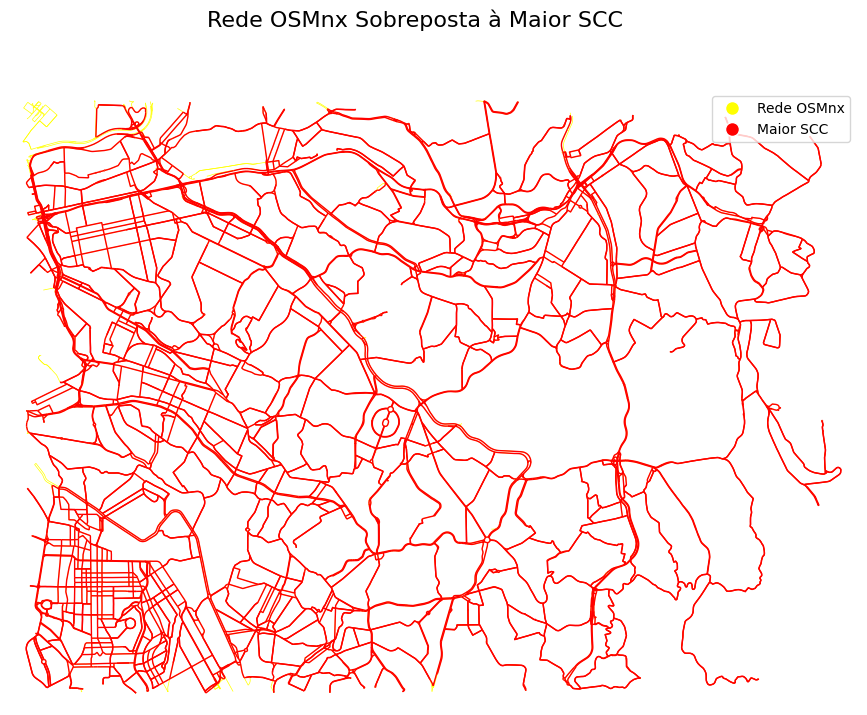

In [240]:
# Identificar os componentes fortemente conectadas (SCCs)
sccs = list(nx.strongly_connected_components(G2))

# Encontrar a maior SCC com base no número de nós
largest_scc = max(sccs, key=len)

# Criar um subgrafo contendo apenas a maior SCC
subgraph_scc = G2.subgraph(largest_scc)

# Plotar a rede OSMnx sobreposta ao subgrafo da maior SCC
fig, ax = plt.subplots(figsize=(15, 8))
ox.plot_graph(G2, ax=ax, node_color='yellow', node_size=0, edge_linewidth=0.5, edge_color= 'yellow', show=False, close=False)
ox.plot_graph(subgraph_scc, ax=ax, node_color='r', node_size=0, edge_linewidth=1.0, edge_color= 'red', show=False, close=False)

# Adicionar título ao plot
fig.suptitle("Rede OSMnx Sobreposta à Maior SCC", fontsize=16)

# Adicionar uma legenda manualmente
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Rede OSMnx')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Maior SCC')

# Colocar a legenda no gráfico
plt.legend(handles=[yellow_patch, red_patch], loc='upper right')

# Mostrar o plot
plt.show()

# TODO melhorar representacáo grafico. arco da maior SCC vermelho e remover pontos. Manter redes em amarelo.

### Carregar os pontos da pesquisa OD referentes a bacia

In [ ]:
# Read the shapefile
gdf_OD = gpd.read_file(pesquisa_OD)

# Verifica o sistema de coordenadas
gdf_OD.crs

# Atribuição do esquema de projeção
gdf_OD = gdf_OD.to_crs(my_crs)
edges2 = edges2.to_crs(my_crs)

# Filtrando para o munícipio de São Paulo
gdf_indices=gdf_OD.index[gdf_OD['NomeMunici']=='São Paulo']
gdf_OD_SP = gdf_OD.loc[gdf_indices]

# Obtendo os centroides
gdf_OD_SP["centroid"] = gdf_OD_SP["geometry"].centroid

if verbose:
    gdf_OD_SP['centroid'].explore(
#                            column = "NumeroZona",
#                            tooltip = "NumeroZona",
#                            popup = True,
#                            tiles = "CartoDB dark_matter",
#                            cmap = "inferno_r")
    )

In [ ]:
base = gdf_OD_SP['centroid'].plot(figsize=(16,16), color='blue')
edges2.plot(ax=base, color='red', alpha=0.2)
ax.set_title('Sobreposição da rede viária das bacias versus centróides OD')

In [ ]:
centroides_df = gpd.GeoDataFrame(geometry=gdf_OD_SP['centroid'])
centroides_dentro = gpd.sjoin(centroides_df, bounding_box_gdf, how='inner', predicate='within')

base2 = centroides_dentro.plot(color='green', figsize=(16,16))
edges2.plot(ax=base2, color='red', alpha=0.2)

centroides_dentro.shape

In [ ]:
# 1. Aproximar os pontos de centroides_dentro à rede
centroides_dentro['nearest_node'] = centroides_dentro['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(G2, point.x, point.y)
)

# 2. Adicionar velocidade aos eixos
G2 = ox.add_edge_travel_times(G2)  # Adiciona o tempo de viagem (segundos)


### Enriquecer a informação de velocidades

In [ ]:
import geopandas as gpd

# Definir o nome do arquivo GeoJSON de entrada
input_file = "vel_atual_maparadar.geojson"

# Ler o arquivo GeoJSON
gdf_maparadar = gpd.read_file(input_file)
gdf_maparadar.crs = my_crs

# Mostrar as primeiras linhas do GeoDataFrame
print(gdf_maparadar.head())


In [ ]:
gdf_maparadar.describe(include='all')

In [ ]:
gdf_maparadar['Tipo'].unique()

In [ ]:
gdf_maparadar['Velocidade'].unique()

In [ ]:
maparadar_dentro = gpd.sjoin(gdf_maparadar, bounding_box_gdf, how='inner', predicate='within')

base3 = maparadar_dentro.plot(color='green', figsize=(16,16))
edges2.plot(ax=base3, color='red', alpha=0.2)

maparadar_dentro.shape

In [ ]:
# Filtrar apenas os radares fixo
gdf_maparadar_muda_vel = maparadar_dentro[maparadar_dentro['Tipo'].str.contains('Radar Fixo|Semaforo com Radar|Semaforo com Camera', regex=True)]

# Remover as linhas onde a coluna 'Velocidade' é igual a '0'
gdf_maparadar_muda_vel = gdf_maparadar_muda_vel[gdf_maparadar_muda_vel['Velocidade'] != '0']

# Filtrar apenas as lombadas
gdf_maparadar_lombadas = maparadar_dentro[maparadar_dentro['Tipo'] == 'Lombada']

# Contar a quantidade de radares fixos
quantidade_itens_maparadar = len(gdf_maparadar_muda_vel)
quantidade_lombadas_maparadar = len(gdf_maparadar_lombadas)

# Exibir a quantidade
print(f'Quantidade de itens com potencial de mudar a velocidade da via de estudo: {quantidade_itens_maparadar}\n')
print(f'Quantidade de lombadas com potencial de mudar o tempo de caminho mínimo: {quantidade_lombadas_maparadar}\n')


In [ ]:
gdf_maparadar_muda_vel['Velocidade'].unique()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

my_crs = '31983'
# Reprojetar as geometrias de edges2 para o CRS projetado
edges2_proj = edges2.to_crs(my_crs)
print(f'Sistema de coordenadas de edges é: {edges2_proj.crs}\n')

# Reprojetar as geometrias de radar_moveis para o CRS projetado
gdf_maparadar_muda_vel_proj = gdf_maparadar_muda_vel.to_crs(my_crs)
print(f'Sistema de coordenadas de gdf_maparadar_radarfixo é: {gdf_maparadar_muda_vel_proj.crs}\n')

# Criar uma nova coluna para armazenar a velocidade das atualizações
edges2_proj['speed_kph_maparadar'] = None

# Função para encontrar o arco mais próximo
def find_nearest_edge(point, edges):
    nearest_edge = edges.geometry.distance(point).idxmin()
    return nearest_edge

# Aproximar cada ponto em gdf_maparadar_radarfixo ao arco mais próximo em edges2
for idx, row in gdf_maparadar_muda_vel_proj.iterrows():
    nearest_edge_idx = find_nearest_edge(row.geometry, edges2_proj)
    edges2_proj.at[nearest_edge_idx, 'speed_kph_maparadar'] = row['Velocidade']

# Preencher os valores nulos com uma velocidade diferente para evitar confusão
edges2_proj['speed_kph_maparadar'] = edges2_proj['speed_kph_maparadar'].fillna(-1)

# Converter a coluna 'speed_kph_maparadar' para float64
edges2_proj['speed_kph_maparadar'] = edges2_proj['speed_kph_maparadar'].astype(float)

# Adicionar a nova condição
mask = (edges2_proj['speed_kph_maparadar'] == -1) & (edges2_proj['speed_kph'] > 0)
edges2_proj.loc[mask, 'speed_kph_maparadar'] = edges2_proj.loc[mask, 'speed_kph']

# Listar todos os pontos onde speed_kph é diferente de speed_kph_maparadar
different_speeds = edges2_proj[edges2_proj['speed_kph'] != edges2_proj['speed_kph_maparadar']]

# Mostrar os pontos onde as velocidades são diferentes
print(different_speeds[['speed_kph', 'speed_kph_maparadar']])

# TODO calcular a correlação entre as velocidades


Vale a pena observar na tabela acima o quanto as velocidades foram alteradas. Para o primeiro exemplo rodado, praticamente um ponto foi mais expressivo, de 65 para 40. Isso reforça que a geração de velocidades sintéticas do OSMnx é bastante razoável para este cenário.


Vamos identificar quantas vias foram atualizadas através desse método.

In [ ]:
print(f'Foram atualizadas {different_speeds.shape[0]} vias com novas velocidades do MapaRadar')

### Calcular o baseline (caminhos mínimos, sem chuva)

É possível utilizar um atributo chamado Maxspeed como peso nas arestas para calcular o caminho mais curto no grafo. No entanto, para usar a velocidade (Maxspeed) diretamente, geralmente é necessário primeiro calcular a distância entre os nós e, em seguida, converter a velocidade em tempo de viagem. Isso ocorre porque a função shortest_path_length precisa de um peso que represente um custo acumulativo, como tempo ou distância.

In [295]:
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/4_Códigos/Dados/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'

In [ ]:
import pandas as pd

# Carregar a planilha no DataFrame
# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
matriz_od = pd.read_excel(arquivo_matrizOD, header=7, index_col=0)

In [306]:
# Exibir as primeiras linhas do DataFrame para verificação
print(matriz_od.head())

              1           2    3           4           5           6  \
NaN         NaN         NaN  NaN         NaN         NaN         NaN   
1    128.247095   86.383235  0.0  191.877452  105.088345  151.710615   
2     86.383235    0.000000  0.0    0.000000  612.400416  256.941702   
3      0.000000    0.000000  0.0    0.000000  194.857696    0.000000   
4      0.000000  214.428586  0.0  372.251396  455.222595    0.000000   

              7           8          9   10  ...  509  510  511  512  513  \
NaN         NaN         NaN        NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
1    234.477033    0.000000   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2      0.000000    0.000000  92.275009  0.0  ...  0.0  0.0  0.0  0.0  0.0   
3      0.000000    0.000000   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   
4      0.000000  159.375738   0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0   

     514  515        516  517         Total  
NaN  NaN  NaN        NaN  NaN           NaN  
1    0.0  0.

In [304]:
# Acessar um valor específico na matriz (por exemplo, origem na zona 2 e destino na zona 3)
# Note que agora as zonas começam em 1
valor = matriz_od.loc[1, 1]
print(f"Valor na origem 4 e destino 2: {valor}")


Valor na origem 4 e destino 2: 128.2470948708196


In [ ]:
# Calcular o tempo de viagem baseado em speed_kph_maparadar
for u, v, k, data in G2.edges(data=True, keys=True):
    if 'speed_kph_maparadar' in data and 'length' in data:
        speedkph = data['speed_kph_maparadar']
        if isinstance(speedkph, list):  # caso maxspeed seja uma lista
            speedkph = speedkph[0]  # use o primeiro valor
        # Converter maxspeed para float e lidar com valores não numéricos
        try:
            speedkph = float(speedkph)
        except ValueError:
            speedkph = 50.0  # atribuir um valor padrão se a conversão falhar
        
        # Calcular o tempo de viagem em segundos
        data['travel_time_based_on_speedkph_maparadar'] = data['length'] / (speedkph / 3.6)
    else:
        data['travel_time_based_on_speedkph_maparadar'] = float('inf')  # Se faltar informação, definir um valor muito alto

In [ ]:
# 3. Calcular o caminho mínimo e o tempo de viagem entre todos os pontos dois a dois
times = []
i = 0
for node1, node2 in combinations(centroides_dentro['nearest_node'], 2):
    try:
        # Calcular o caminho mínimo pelo tempo de viagem
        time = nx.shortest_path_length(G2, source=node1, target=node2, weight='travel_time_based_on_speedkph')
        # Calcular o caminho completo pelo tempo de viagem
        path = nx.shortest_path(G2, source=node1, target=node2, weight='travel_time_based_on_speedkph', cpus=5)
        # Plotar os pontos na rede
        fig, ax = ox.plot_graph(G2, edge_color='lightgray', show=False, close=False, figsize=(16,16))
        if i % 1000 == 0:
            ox.plot_graph_route(G2, path, ax=ax, route_linewidth=2, route_color='blue',orig_dest_node_color='red', orig_dest_size=150, orig_dest_color='red')
            plt.show()
            plt.close()
        times.append(time)
        #print(f'Interação: {i}  O tempo de deslocamento entre o {node1} e o {node2} foi de {time}')
        i +=1
    except nx.NetworkXNoPath:
        # Se não houver caminho entre os nós, ignore esse par
        continue
        
# TODO ponderar a matriz OD pela matriz OD com o número de viagens.

In [ ]:

# 4. Calcular o tempo médio de viagem
if times:
    average_time = sum(times) / len(times)
    # Converter o tempo médio de segundos para minutos
    average_time_minutes = average_time / 60
    print(f"Tempo médio de viagem entre todos os pontos: {average_time_minutes:.2f} minutos")
else:
    print("Nenhum caminho encontrado entre os pontos.")

# Plotar os pontos na rede
fig, ax = ox.plot_graph(G2, edge_color='lightgray', show=False, close=False, figsize=(16,16))

# Plotar os centroides em verde
centroides_dentro.plot(ax=ax, color='green', markersize=50, label='Centroides')

# Plotar os nós mais próximos em vermelho
nearest_nodes = centroides_dentro['nearest_node'].unique()
nearest_node_coords = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in nearest_nodes]
x, y = zip(*nearest_node_coords)
ax.scatter(x, y, c='red', s=50, label='Nearest Nodes')

# Adicionar título ao plot
fig.suptitle("Centróides OD aproximados da rede OSM", fontsize=16)

# Adicionar uma legenda manualmente
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Centróides OD')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Ponto aproximado na rede')

# Colocar a legenda no gráfico
plt.legend(handles=[green_patch, red_patch], loc='upper right')

# Adicionar os caminhos mínimos
#for (node1, node2) in combinations(centroides_dentro['nearest_node'], 2):
#    try:
#        path = nx.shortest_path(G2, source=node1, target=node2, weight='travel_time')
#        ox.plot_graph_route(G2, path, ax=ax, route_linewidth=2, route_color='blue', orig_dest_node_color='red')
#    except nx.NetworkXNoPath:
#        continue

# TODO: Testar como isso funciona
plt.show()

### Carregar o raster da simulação

In [ ]:
arquivo_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/4_Códigos/Qualificação/14_106.tif'

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import osmnx as ox
from shapely.geometry import Point, LineString
from matplotlib import pyplot as plt
from rasterio.plot import show

# Carregar a imagem raster
dataset_raster = rasterio.open(arquivo_raster)
dataset_raster.meta

In [ ]:
# Ajustar o sistema de coordendas da rede
edges2_proj_utm = edges2_proj.to_crs(epsg=31983)
edges2_proj_utm.crs

In [ ]:
import rasterio
import numpy as np

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    raster = src.read(1)
    raster_transform = src.transform

# Remover valores de no data se houver
no_data_value = src.nodata
if no_data_value is not None:
    raster = np.ma.masked_equal(raster, no_data_value)

# Calcular estatísticas descritivas
mean_value = np.mean(raster)
median_value = np.median(raster)
std_dev = np.std(raster)
min_value = np.min(raster)
max_value = np.max(raster)
percentiles = np.percentile(raster, [25, 50, 75])

# Exibir os resultados
print(f'Média: {mean_value}')
print(f'Mediana: {median_value}')
print(f'Desvio Padrão: {std_dev}')
print(f'Valor Mínimo: {min_value}')
print(f'Valor Máximo: {max_value}')
print(f'Percentil 25: {percentiles[0]}')
print(f'Percentil 50: {percentiles[1]}')
print(f'Percentil 75: {percentiles[2]}')

# TODO Calcular a média sem os no-value

In [ ]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
from shapely.ops import split
import multiprocessing

# Carregar o raster
raster = rasterio.open(arquivo_raster)

In [ ]:
# Obter as dimensões do raster
ncols, nrows = raster.width, raster.height
xmin, ymin, xmax, ymax = raster.bounds
xres = (xmax - xmin) / ncols
yres = (ymax - ymin) / nrows

# Criar uma lista de polígonos representando os pixels do raster
polygons = []
for i in range(nrows):
    for j in range(ncols):
        x1 = xmin + j * xres
        x2 = x1 + xres
        y1 = ymax - i * yres
        y2 = y1 - yres
        polygons.append(box(x1, y1, x2, y2))

# Criar um GeoDataFrame a partir dos polígonos
grid_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=edges2.crs)

In [ ]:
def segment_line_with_grid(line, grid):
    segments = []
    for polygon in grid.geometry:
        intersection = line.intersection(polygon)
        if not intersection.is_empty:
            if intersection.geom_type == 'LineString':
                segments.append((intersection, polygon))
            elif intersection.geom_type == 'MultiLineString':
                for seg in intersection:
                    segments.append((seg, polygon))
    return segments

In [ ]:
def process_line_chunks(lines_chunk, grid_gdf):
    segmented_lines = []
    for line in lines_chunk:
        segmented_lines.extend(segment_line_with_grid(line, grid_gdf))
    return segmented_lines

# Função para dividir o GeoDataFrame em chunks
def chunkify(df, n):
    return [df[i::n] for i in range(n)]

# Dividir as linhas em chunks
num_cores = multiprocessing.cpu_count()
chunks = chunkify(edges2_proj_utm.geometry, num_cores)

# Criar um pool de processos e processar os chunks
with multiprocessing.Pool(num_cores) as pool:
    results = pool.starmap(process_line_chunks, [(chunk, grid_gdf) for chunk in chunks])

# Combinar os resultados dos chunks
segmented_lines = [item for sublist in results for item in sublist]

# Criar um novo GeoDataFrame com as linhas segmentadas
segmented_geometries = [seg[0] for seg in segmented_lines]
segmented_values = [seg[1].value for seg in segmented_lines]
segmented_gdf = gpd.GeoDataFrame({'geometry': segmented_geometries, 'value': segmented_values}, crs=edges2_proj_utm.crs)



In [ ]:
# Intersectar a rede viária com os polígonos do grid
segmented_roads = gpd.overlay(edges2_proj_utm, grid_gdf, how='intersection')

# Garantir que as linhas segmentadas não se transformem em polígonos
segmented_roads = segmented_roads.explode(index_parts=False).reset_index(drop=True)

In [196]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

In [198]:
def segmentize_gdf(gdf, distance):
    new_geometries = []
    new_attributes = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        attributes = row.drop('geometry')
        
        redistributed = redistribute_vertices(geom, distance)
        
        if redistributed.geom_type == 'LineString':
            for i in range(len(redistributed.coords) - 1):
                segment = LineString([redistributed.coords[i], redistributed.coords[i + 1]])
                new_geometries.append(segment)
                new_attributes.append(attributes)
        elif redistributed.geom_type == 'MultiLineString':
            for part in redistributed:
                for i in range(len(part.coords) - 1):
                    segment = LineString([part.coords[i], part.coords[i + 1]])
                    new_geometries.append(segment)
                    new_attributes.append(attributes)
    
    new_gdf = gpd.GeoDataFrame(new_attributes, geometry=new_geometries, crs=gdf.crs)
    return new_gdf

In [228]:
import time

start_time = time.time()
# Segmentar a rede viária em intervalos de 500m
segmented_edges2 = segmentize_gdf(edges2_proj_utm, 10)
end_time = time.time()

execution_time = end_time - start_time
print(f'Segmentized edges2: {execution_time:.2f} segundos')

Segmentized edges2: 16.05 segundos


In [229]:
print(f'O total de linhas originais é {edges2_proj_utm.shape[0]} linhas')
print(f'Já o método de quebra produziu {segmented_edges2.shape[0]} linhas')

O total de linhas originais é 7667 linhas
Já o método de quebra produziu 156314 linhas


In [230]:
import geopandas as gpd
from shapely.geometry import Point, LineString

def extract_nodes_from_segments(gdf):
    nodes = set()
    for line in gdf.geometry:
        coords = list(line.coords)
        nodes.add(Point(coords[0]))
        nodes.add(Point(coords[-1]))
    return list(nodes)

# Extraímos os nós dos segmentos da rede segmentada
nodes = extract_nodes_from_segments(segmented_edges2)

# Criar um GeoDataFrame para os nós
nodes_gdf = gpd.GeoDataFrame(geometry=nodes, crs=segmented_edges2.crs)


In [260]:
def create_edges_from_segments(gdf):
    edges = []
    for idx, row in gdf.iterrows():
        line = row['geometry']
        coords = list(line.coords)
        start_node = Point(coords[0])
        end_node = Point(coords[-1])
        edge_attributes = row.drop('geometry').to_dict()  # Excluir a geometria para adicionar os atributos restantes
        edge_attributes['geometry'] = line  # Adicionar a geometria novamente como shapely object
        edge_attributes['start'] = start_node  # Adicionar o nó de início
        edge_attributes['end'] = end_node  # Adicionar o nó de término
        edges.append(edge_attributes)
    return edges

In [261]:
# Criar arestas a partir dos segmentos da rede segmentada
edges = create_edges_from_segments(segmented_edges2)

# Criar um GeoDataFrame para as arestas com todos os atributos de segmented_edges2
edges_gdf = gpd.GeoDataFrame(
    edges,  # A lista de dicionários de atributos
    geometry='geometry',
    crs=segmented_edges2.crs
)

# Verificar se os atributos foram transferidos corretamente
print(edges_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 156314 entries, 0 to 156313
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   osmid                156314 non-null  object  
 1   oneway               156314 non-null  bool    
 2   lanes                144340 non-null  object  
 3   ref                  8408 non-null    object  
 4   name                 151306 non-null  object  
 5   highway              156314 non-null  object  
 6   maxspeed             156314 non-null  object  
 7   reversed             156314 non-null  object  
 8   length               156314 non-null  float64 
 9   speed_kph            156314 non-null  float64 
 10  bridge               13006 non-null   object  
 11  access               841 non-null     object  
 12  tunnel               1195 non-null    object  
 13  junction             584 non-null     object  
 14  width                148 non-null     object

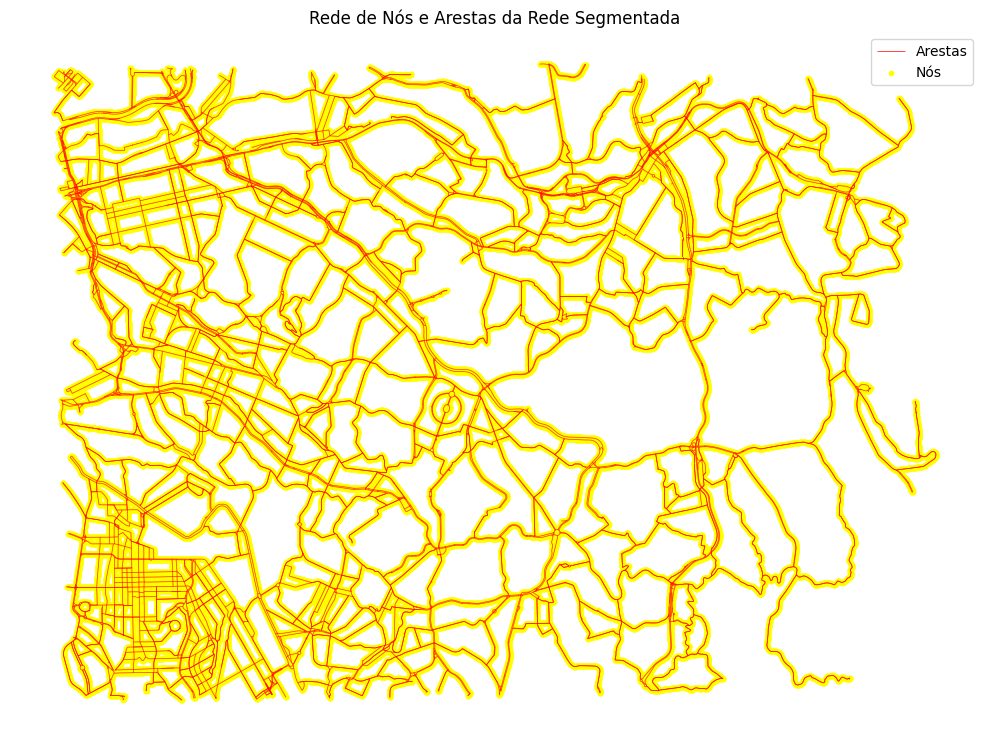

In [262]:
import matplotlib.pyplot as plt

# Criar uma figura para plotar os nós e as arestas
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as arestas
edges_gdf.plot(ax=ax, color='red', linewidth=0.5, label='Arestas')

# Plotar os nós
nodes_gdf.plot(ax=ax, color='yellow', markersize=10, label='Nós')

# Adicionar título e legenda
ax.set_title('Rede de Nós e Arestas da Rede Segmentada')
ax.legend()

# Ajustar a visualização
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [263]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString

# Criar um grafo direcionado
G3 = nx.DiGraph()

# Adicionar nós e arestas ao grafo a partir do GeoDataFrame
for idx, row in edges_gdf.iterrows():
    start = row['start']
    end = row['end']
    G3.add_edge((start.x, start.y), (end.x, end.y), geometry=row['geometry'])

# Verificar se os nós e arestas foram adicionados corretamente
print(f"Número de nós: {G3.number_of_nodes()}")
print(f"Número de arestas: {G3.number_of_edges()}")


Número de nós: 113127
Número de arestas: 156314


In [264]:
# Identificar os componentes fortemente conectados (SCCs)
sccs = list(nx.strongly_connected_components(G3))

# Encontrar a maior SCC com base no número de nós
largest_scc = max(sccs, key=len)

# Criar um subgrafo contendo apenas a maior SCC
subgraph_scc = G3.subgraph(largest_scc)


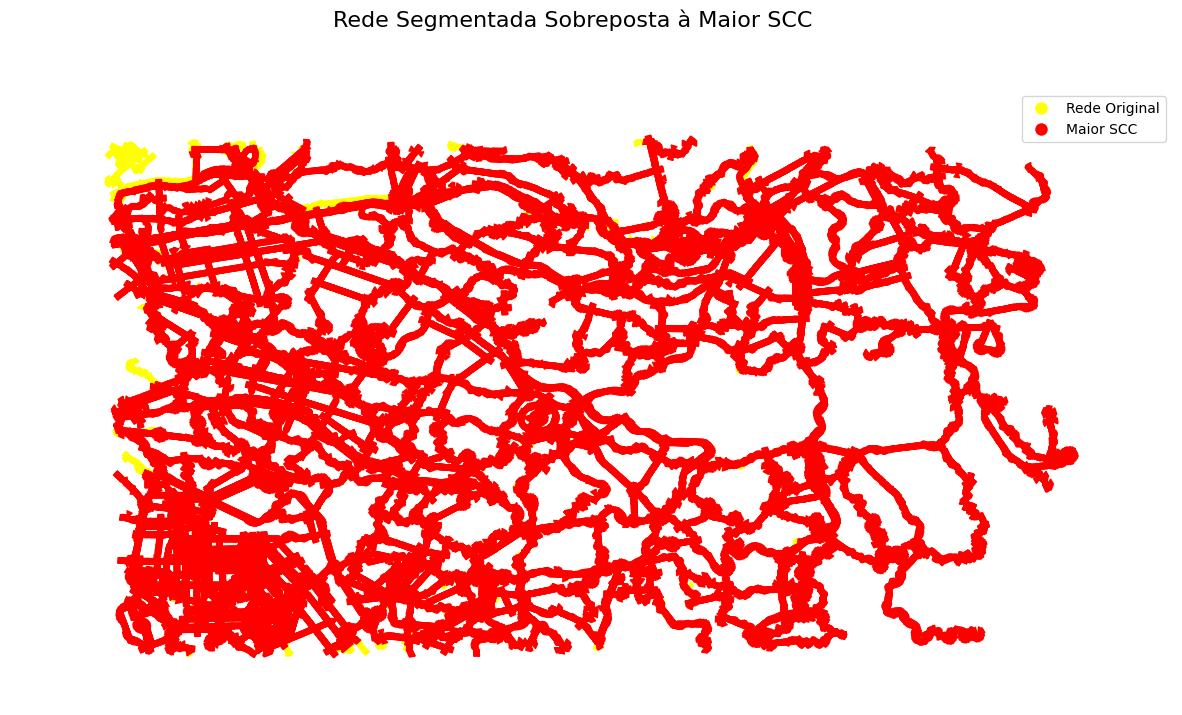

In [265]:
import matplotlib.pyplot as plt

# Função para desenhar o grafo
def plot_graph(G, ax, node_color='yellow', node_size=10, edge_color='black', edge_linewidth=0.5):
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, ax=ax, node_color=node_color, node_size=node_size,
            edge_color=edge_color, width=edge_linewidth, with_labels=False)

# Criar uma figura e eixos para plotar os grafos
fig, ax = plt.subplots(figsize=(15, 8))

# Plotar o grafo original
plot_graph(G3, ax=ax, node_color='yellow', node_size=00, edge_color='yellow', edge_linewidth=0.5)

# Plotar o subgrafo da maior SCC
plot_graph(subgraph_scc, ax=ax, node_color='red', node_size=0, edge_color='red', edge_linewidth=1.0)

# Adicionar título ao plot
fig.suptitle("Rede Segmentada Sobreposta à Maior SCC", fontsize=16)

# Adicionar uma legenda manualmente
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Rede Original')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Maior SCC')

# Colocar a legenda no gráfico
plt.legend(handles=[yellow_patch, red_patch], loc='upper right')

# Mostrar o plot
plt.show()


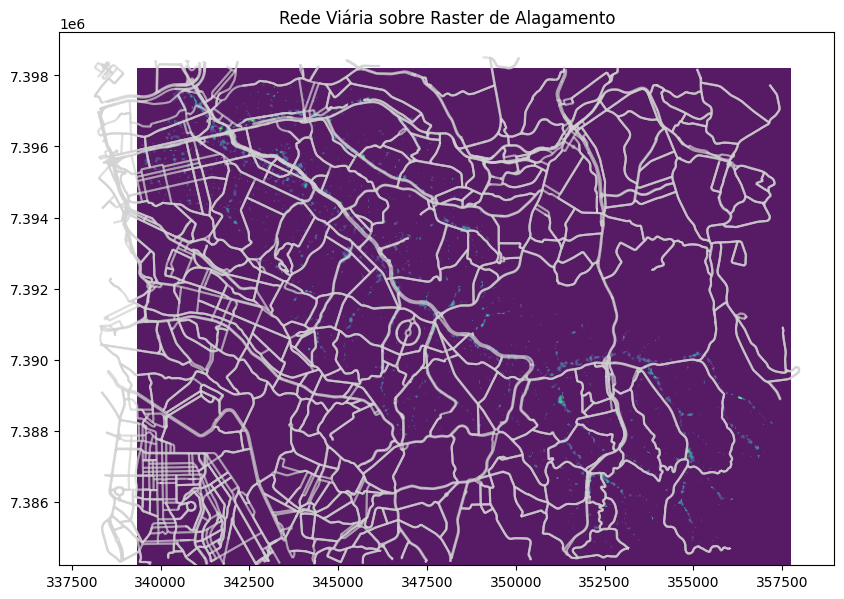

In [266]:
# Criar o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(dataset_raster, ax=ax, cmap='viridis', alpha=0.9)

# Plotar a rede viária
edges_gdf.plot(ax=ax, color='lightgray')

# Configurar título e eixos
ax.set_title('Rede Viária sobre Raster de Alagamento')
plt.show()

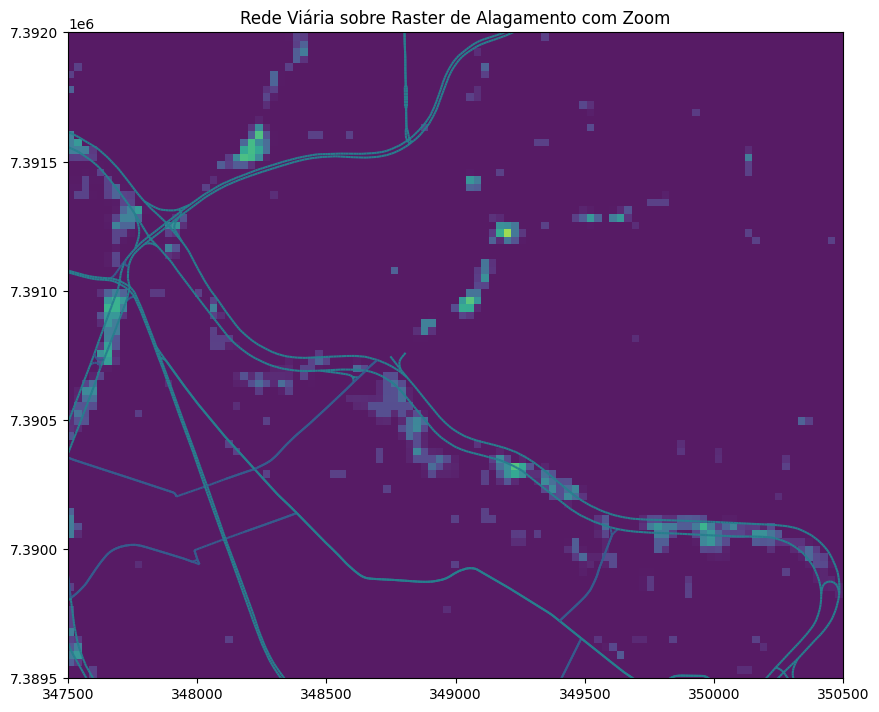

In [267]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Definir os limites para o zoom (em coordenadas EPSG:31983)
# Substitua estes valores pelos limites desejados
zoom_min_x = 347500  # Coordenada mínima x
zoom_max_x = 350500  # Coordenada máxima x
zoom_min_y = 7389500 # Coordenada mínima y
zoom_max_y = 7392000 # Coordenada máxima y

# Criar o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
show(dataset_raster, ax=ax, cmap='viridis', alpha=0.9)

# Adicionar contornos
#contours = ax.contour(dataset_raster, levels=np.arange(0,9, 1), colors='black')
#ax.clabel(contours, inline=True, fontsize=8)

# Plotar a rede viária
edges_gdf.plot(column='speed_kph_maparadar', ax=ax, cmap='viridis')

# Ajustar os limites dos eixos para dar zoom
ax.set_xlim(zoom_min_x, zoom_max_x)
ax.set_ylim(zoom_min_y, zoom_max_y)

# Configurar título e eixos
ax.set_title('Rede Viária sobre Raster de Alagamento com Zoom')
plt.show()

# TODO tentar segmentar a rede pelo tamanho pixel

In [270]:
# Carregar o raster
raster = rasterio.open(arquivo_raster)

# Ler os dados do raster
raster_data = raster.read(1)  # Lê a primeira banda do raster

# Determinar os pixels acima do threshold
threshold = 0.3  # Valor definido, neste momento, de forma aleatória.
mask = raster_data > threshold

In [271]:
# Criar geometrias para os pixels selecionados
def pixel_to_geometry(row, col, transform):
    minx, miny = transform * (col, row)
    maxx, maxy = transform * (col + 1, row + 1)
    return box(minx, miny, maxx, maxy)

In [273]:
geometries = [pixel_to_geometry(row, col, raster_transform)
              for row, col in np.argwhere(mask)]

# Criar um GeoDataFrame com os pixels selecionados
flooded_areas = gpd.GeoDataFrame({'geometry': geometries}, crs=src.crs)

# Encontrar interseções entre os pixels selecionados e a rede viária
intersections = gpd.overlay(edges_gdf, flooded_areas, how='intersection')

# Alterar a velocidade das vias nas interseções
def adjust_speed(row, raster_data, transform):
     # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid
    col_idx, row_idx = ~transform * (centroid.x, centroid.y)  # Observe a ordem inversa
    row_idx, col_idx = int(row_idx), int(col_idx)

    # Verificar se os índices estão dentro dos limites do array
    if 0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]:
        if raster_data[row_idx, col_idx] > threshold:
            return raster_data[row_idx, col_idx]
    return row['speed_kph_maparadar']

edges_gdf['new_speed_flooding'] = edges_gdf.apply(adjust_speed, axis=1, args=(raster_data, raster_transform))


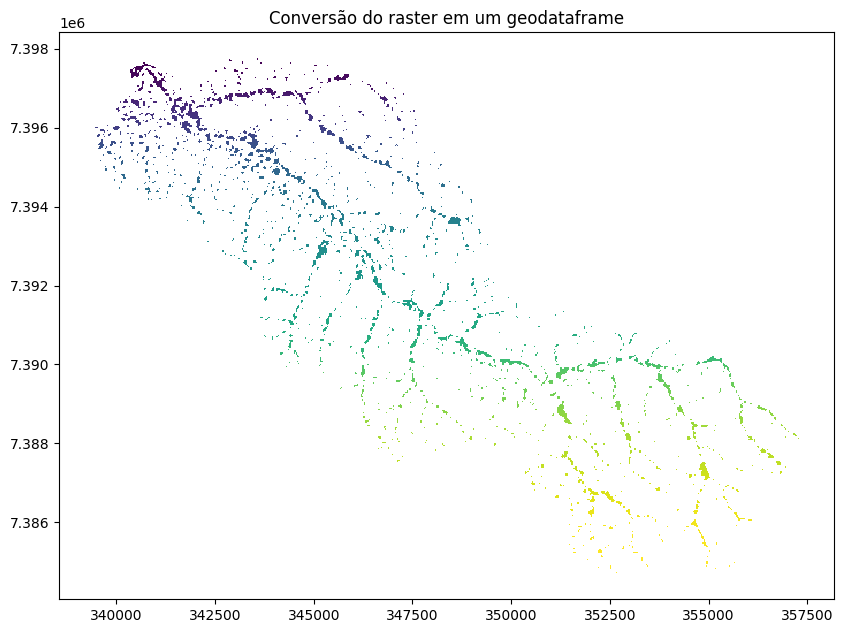

In [274]:
# Verificando a conversão do raster em GDF
fig, ax2 = plt.subplots(figsize=(10, 10))
plt.style.use('default')
flooded_areas.plot(ax=ax2, figsize=(10, 10), cmap='viridis', facecolor='white')
ax2.set_title('Conversão do raster em um geodataframe')
plt.show()

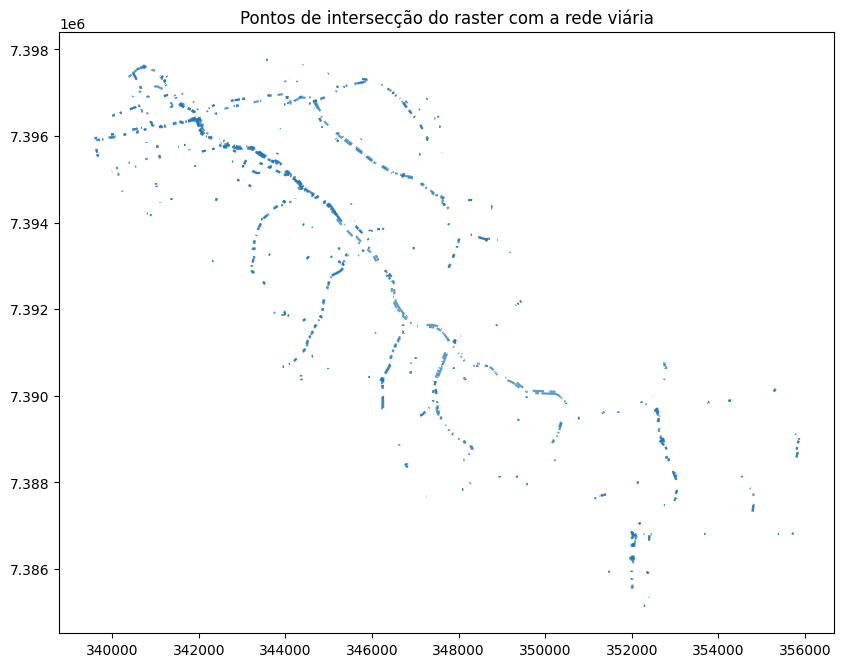

In [275]:
fig, ax3 = plt.subplots(figsize=(10, 10))
intersections.plot(ax=ax3, figsize=(10, 10), cmap='viridis', column='new_speed_flooding', facecolor='white')
ax3.set_title('Pontos de intersecção do raster com a rede viária')
plt.show()


In [276]:
intersections.head()

,osmid,oneway,lanes,ref,name,highway,maxspeed,reversed,length,speed_kph,bridge,access,tunnel,junction,width,speed_kph_maparadar,new_speed_flooding,start,end,geometry
0,"[853102158, 226165425, 226165422]",True,"[1, 2]",NaN,Saída Avenida Aricanduva,motorway_link,"[50, 70]",False,471.011,60.0,yes,NaN,NaN,NaN,NaN,60.0,60.0,POINT (340696.2949514137 7397601.442375649),POINT (340705.60953023407 7397597.712828251),"LINESTRING (340701.478 7397599.367, 340705.610..."
1,"[853102158, 226165425, 226165422]",True,"[1, 2]",NaN,Saída Avenida Aricanduva,motorway_link,"[50, 70]",False,471.011,60.0,yes,NaN,NaN,NaN,NaN,60.0,60.0,POINT (340705.60953023407 7397597.712828251),POINT (340714.7800335442 7397593.693905152),"LINESTRING (340705.610 7397597.713, 340714.020..."
2,"[853102158, 226165425, 226165422]",True,"[1, 2]",NaN,Saída Avenida Aricanduva,motorway_link,"[50, 70]",False,471.011,60.0,yes,NaN,NaN,NaN,NaN,60.0,60.0,POINT (340705.60953023407 7397597.712828251),POINT (340714.7800335442 7397593.693905152),"LINESTRING (340714.020 7397594.027, 340714.780..."
3,"[853102158, 226165425, 226165422]",True,"[1, 2]",NaN,Saída Avenida Aricanduva,motorway_link,"[50, 70]",False,471.011,60.0,yes,NaN,NaN,NaN,NaN,60.0,60.0,POINT (340714.7800335442 7397593.693905152),POINT (340723.3700373401 7397588.509048628),"LINESTRING (340714.780 7397593.694, 340723.370..."
4,"[853102158, 226165425, 226165422]",True,"[1, 2]",NaN,Saída Avenida Aricanduva,motorway_link,"[50, 70]",False,471.011,60.0,yes,NaN,NaN,NaN,NaN,60.0,60.0,POINT (340723.3700373401 7397588.509048628),POINT (340731.960041136 7397583.324192102),"LINESTRING (340723.370 7397588.509, 340730.637..."


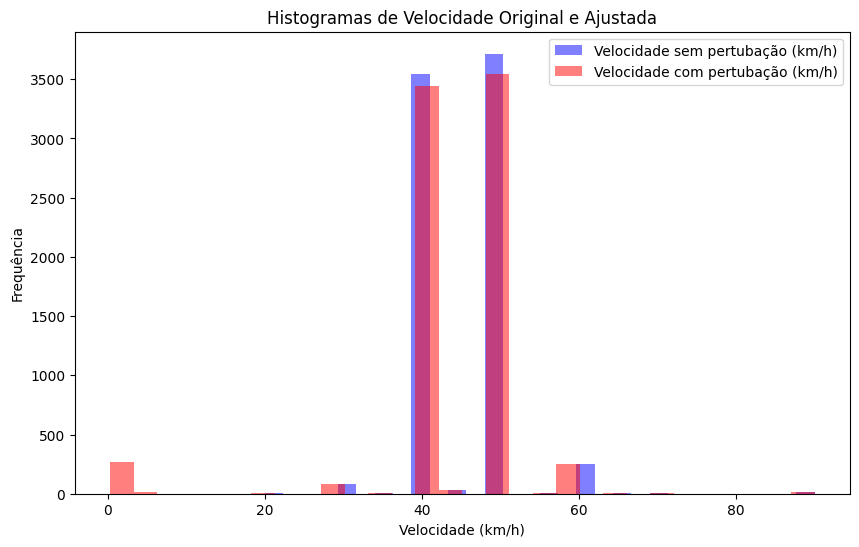

In [277]:
# Criar histogramas sobrepostos
plt.figure(figsize=(10, 6))

# Histograma para speed_kph_maparadar
plt.hist(edges2_proj_utm['speed_kph_maparadar'], bins=30, alpha=0.5, label='Velocidade sem pertubação (km/h)', color='blue')

# Histograma para new_speed_flooding
plt.hist(edges2_proj_utm['new_speed_flooding'], bins=30, alpha=0.5, label='Velocidade com pertubação (km/h)', color='red')

# Adicionar título e rótulos
plt.title('Histogramas de Velocidade Original e Ajustada')
plt.xlabel('Velocidade (km/h)')
plt.ylabel('Frequência')
plt.legend()

# Mostrar o gráfico
plt.show()

(7394000.0, 7398000.0)

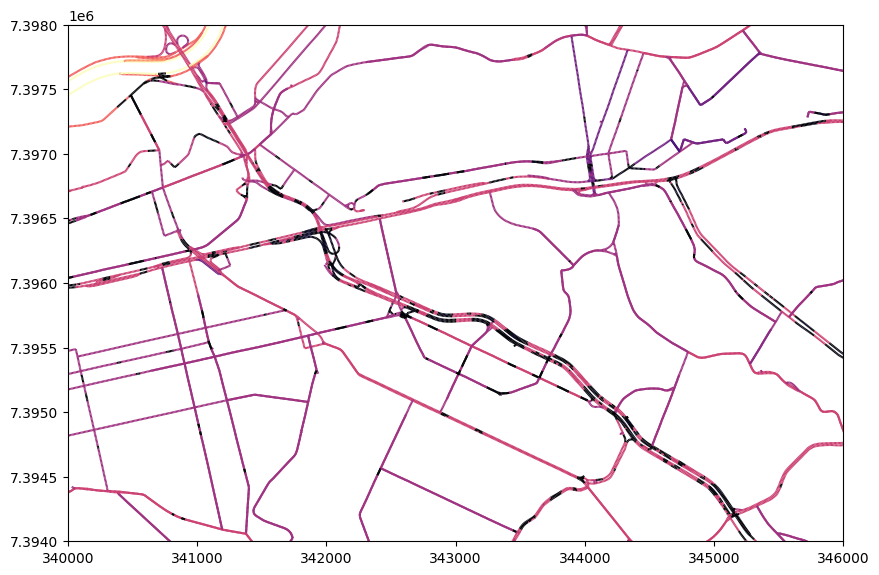

In [294]:
# Definir os limites para o zoom (em coordenadas EPSG:31983)
# Substitua estes valores pelos limites desejados
zoom_min_x = 340000  # Coordenada mínima x
zoom_max_x = 346000  # Coordenada máxima x
zoom_min_y = 7394000 # Coordenada mínima y
zoom_max_y = 7398000 # Coordenada máxima y

# Criar o plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o raster
#show(dataset_raster, ax=ax, cmap='viridis', alpha=0.9)

# Adicionar contornos
#contours = ax.contour(dataset_raster, levels=np.arange(0,9, 1), colors='black')
#ax.clabel(contours, inline=True, fontsize=8)

# Plotar a rede viária
edges_gdf.plot(column='new_speed_flooding', ax=ax, cmap='magma')

# Ajustar os limites dos eixos para dar zoom
ax.set_xlim(zoom_min_x, zoom_max_x)
ax.set_ylim(zoom_min_y, zoom_max_y)

In [282]:
# Listar todos os pontos onde speed_kph é diferente de speed_kph_maparadar
different_speeds = edges2_proj_utm[edges2_proj_utm['speed_kph_maparadar'] != edges2_proj_utm['new_speed_flooding']]

# Mostrar os pontos onde as velocidades são diferentes
print(different_speeds.shape)
print(different_speeds[['speed_kph_maparadar', 'new_speed_flooding']])


(282, 18)
                            speed_kph_maparadar  new_speed_flooding
u           v          key                                         
25781788    25781744   0                   60.0            0.874722
25781795    25781744   0                   60.0            0.852579
129959067   135566143  0                   40.0            0.919606
129960037   7934375830 0                   40.0            1.000646
129960040   129960043  0                   40.0            1.001316
...                                         ...                 ...
8812225714  8812225715 0                   50.0            1.096754
            2477132028 0                   50.0            1.097374
8812225715  2477144831 0                   50.0            1.006043
9892321104  9892321111 0                   40.0            0.482256
10671569919 438679739  0                   50.0            0.730962

[282 rows x 2 columns]


### Atualizar velocidades em função das lâminas d'água

### Calcular o caminho mínimo, com chuva

### Montar o histograma